### Importing libraries

In [76]:
%pip install pycaret[models] shap autofeat preprocessing optuna

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Benoj\.pyenv\pyenv-win\versions\3.10.0\python.exe -m pip install --upgrade pip' command.


In [77]:

# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pycaret.classification import *
from pycaret.regression import *

# machine learning
import optuna
import sklearn.datasets
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Split train_data
import sklearn.model_selection
from sklearn.model_selection import train_test_split

##from google.colab import files
import warnings
warnings.filterwarnings('ignore')

import preprocessing 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_validate



### 1. Load the dataset

In [78]:
# Load files into a pandas dataframe
train = pd.read_csv('Train.csv')
comp_pred = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')
variables = pd.read_csv('VariableDefinitions.csv')

In [79]:
# Let’s observe the shape of our datasets.
print('train data shape :', train.shape)
print('test data shape :', comp_pred.shape)

train data shape : (23524, 13)
test data shape : (10086, 12)


In [80]:
# inspect train data
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [81]:
# Check for missing values
print('missing values:', train.isnull().sum())

missing values: country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64


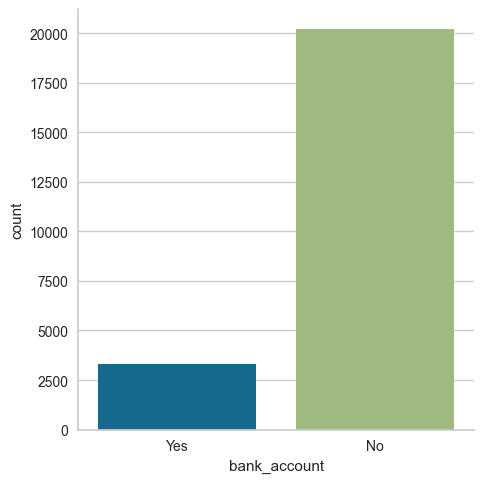

In [82]:
# Explore Target distribution 
sns.catplot(x="bank_account", kind="count", data=train)

In [83]:
# view the submission file
ss.head()

,unique_id,bank_account
0,uniqueid_1 x Kenya,0
1,uniqueid_2 x Kenya,0
2,uniqueid_3 x Kenya,0
3,uniqueid_4 x Kenya,0
4,uniqueid_5 x Kenya,0


In [84]:
 #show some information about the dataset
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB
None


In [85]:
# Let's view the variables
variables

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,The interviewee’s relationship with the head o...
9,marital_status,The martial status of the interviewee: Married...


In [86]:
#import preprocessing module
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Cobvert target label to numerical Data
le = LabelEncoder()
train['bank_account'] = le.fit_transform(train['bank_account'])

#Separate training features from target
X_train = train.drop(['bank_account'], axis=1)
y_train = train['bank_account']

print(y_train)

0        1
1        0
2        1
3        0
4        0
        ..
23519    0
23520    0
23521    0
23522    0
23523    0
Name: bank_account, Length: 23524, dtype: int32


In [87]:
# function to preprocess our data from train models
def preprocessing_data(data):

    # Convert the following numerical labels from interger to float
    float_array = data[["household_size", "age_of_respondent", "year"]].values.astype(float)
    
    # categorical features to be onverted to One Hot Encoding
    categ = ["relationship_with_head",
             "marital_status",
             "education_level",
             "job_type",
             "country"]
    
    # One Hot Encoding conversion
    data = pd.get_dummies(data, prefix_sep="_", columns=categ)
    
    # Label Encoder conversion
    data["location_type"] = le.fit_transform(data["location_type"])
    data["cellphone_access"] = le.fit_transform(data["cellphone_access"])
    data["gender_of_respondent"] = le.fit_transform(data["gender_of_respondent"])
    
    # drop uniquid column
    data = data.drop(["uniqueid"], axis=1)
    
    # scale our data into range of 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)
    
    return data                  

In [88]:
# preprocess the train data 
processed_train = preprocessing_data(X_train)
processed_test = preprocessing_data(comp_pred)

In [89]:
# the first train row
print(processed_train[:1])

[[1.        0.        1.        0.1       0.0952381 0.        0.
  0.        0.        0.        0.        1.        0.        0.
  1.        0.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        1.        1.        0.
  0.        0.       ]]


In [90]:
# shape of the processed train set
print(processed_train.shape)
print(processed_train)

(23524, 37)
[[1. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 0. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 0. 0. 1.]
 [1. 0. 1. ... 0. 0. 1.]]


In [91]:
import sklearn.model_selection

In [92]:
# Split train_data
from sklearn.model_selection import train_test_split

X_Train, X_Val, y_Train, y_val = train_test_split(processed_train, y_train, stratify = y_train, 
                                                  test_size = 0.1, random_state=42)

In [93]:
cat_features = ["relationship_with_head",
             "marital_status",
             "education_level",
             "job_type",
             "country"]
experiment = setup(train, target="bank_account",session_id= 123)


,Description,Value
0,Session id,123
1,Target,bank_account
2,Target type,Regression
3,Original data shape,"(23524, 13)"
4,Transformed data shape,"(23524, 39)"
5,Transformed train set shape,"(16466, 39)"
6,Transformed test set shape,"(7058, 39)"
7,Ordinal features,3
8,Numeric features,3
9,Categorical features,9


In [94]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,0.1653,0.1059,0.3253,0.1307,0.2284,0.7100,0.1100
omp,Orthogonal Matching Pursuit,0.2333,0.1141,0.3378,0.0631,0.2370,0.8032,0.0970
llar,Lasso Least Angle Regression,0.2438,0.1219,0.3491,-0.0004,0.2445,0.8579,0.0970
dummy,Dummy Regressor,0.2438,0.1219,0.3491,-0.0004,0.2445,0.8579,0.1060
en,Elastic Net,0.2438,0.1219,0.3491,-0.0004,0.2445,0.8579,0.0980
lasso,Lasso Regression,0.2438,0.1219,0.3491,-0.0004,0.2445,0.8579,0.2380
par,Passive Aggressive Regressor,0.1984,0.1260,0.3548,-0.0333,0.2434,0.9197,0.0960
ridge,Ridge Regression,0.2333,0.1329,0.3645,-0.0913,0.2586,0.7179,0.0960
br,Bayesian Ridge,0.2373,0.1383,0.3719,-0.1361,0.2634,0.7242,0.0990
lr,Linear Regression,0.2376,0.1386,0.3723,-0.1387,0.2637,0.7248,0.2800


In [95]:
results = pull()

In [96]:
print(results)

                                    Model          MAE           MSE  \
knn                 K Neighbors Regressor       0.1653  1.059000e-01   
omp           Orthogonal Matching Pursuit       0.2333  1.141000e-01   
llar         Lasso Least Angle Regression       0.2438  1.219000e-01   
dummy                     Dummy Regressor       0.2438  1.219000e-01   
en                            Elastic Net       0.2438  1.219000e-01   
lasso                    Lasso Regression       0.2438  1.219000e-01   
par          Passive Aggressive Regressor       0.1984  1.260000e-01   
ridge                    Ridge Regression       0.2333  1.329000e-01   
br                         Bayesian Ridge       0.2373  1.383000e-01   
lr                      Linear Regression       0.2376  1.386000e-01   
huber                     Huber Regressor       0.1426  1.403000e-01   
gbr           Gradient Boosting Regressor       0.2219  1.655000e-01   
lightgbm  Light Gradient Boosting Machine       0.2135  1.685000

In [97]:
predict_model(best_model,train.tail())

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,bank_account,prediction_label
23519,Uganda,2018,uniqueid_2113,Rural,Yes,4,48,Female,Head of Household,Divorced/Seperated,No formal education,Other Income,0,0.0
23520,Uganda,2018,uniqueid_2114,Rural,Yes,2,27,Female,Head of Household,Single/Never Married,Secondary education,Other Income,0,0.2
23521,Uganda,2018,uniqueid_2115,Rural,Yes,5,27,Female,Parent,Widowed,Primary education,Other Income,0,0.0
23522,Uganda,2018,uniqueid_2116,Urban,Yes,7,30,Female,Parent,Divorced/Seperated,Secondary education,Self employed,0,0.0
23523,Uganda,2018,uniqueid_2117,Rural,Yes,10,20,Male,Child,Single/Never Married,Secondary education,No Income,0,0.0


In [98]:
from autofeat import AutoFeatClassifier, FeatureSelector

In [99]:
afc = AutoFeatClassifier(verbose=1,n_jobs=-1)

In [100]:
X_train_feat = afc.fit_transform(X_Train,y_Train)

[AutoFeat] The 2 step feature engineering process could generate up to 33670 features.
[AutoFeat] With 21171 data points this new feature matrix would use about 2.85 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 12 transformed features from 37 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 1030 feature combinations from 1176 original feature tuples - done.
[feateng] Generated altogether 1188 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 910 additional features
[featsel] Scaling data...done.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 21.4min remaining: 32.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 21.8min remaining: 14.5min
[Parallel(n_jobs=-1)]: D

In [101]:
X_Val_feat = afc.transform(X_Val)

[AutoFeat] Computing 13 new features.
[AutoFeat]    13/   13 new features ...done.


In [102]:
lgbm = LGBMClassifier()

In [103]:
lgbm.fit(X_train_feat, y_Train)

[LightGBM] [Info] Number of positive: 2981, number of negative: 18190
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 462
[LightGBM] [Info] Number of data points in the train set: 21171, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.140806 -> initscore=-1.808613
[LightGBM] [Info] Start training from score -1.808613


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=None, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [104]:
y_pred_lgbm = lgbm.predict(X_Val_feat)

In [105]:
lgbm.fit(X_train_feat, y_Train)

[LightGBM] [Info] Number of positive: 2981, number of negative: 18190
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 462
[LightGBM] [Info] Number of data points in the train set: 21171, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.140806 -> initscore=-1.808613
[LightGBM] [Info] Start training from score -1.808613


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=None, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [106]:
comp_feat = afc.transform(processed_test)

[AutoFeat] Computing 13 new features.
[AutoFeat]    13/   13 new features ...done.


In [107]:
submission_pred = lgbm.predict(comp_feat)

In [108]:
# Create submission DataFrame
submission = pd.DataFrame({"uniqueid": comp_pred["uniqueid"] + " x " + comp_pred["country"],
                           "bank_account": submission_pred})

In [109]:
submission.sample(5)

,uniqueid,bank_account
2086,uniqueid_8155 x Kenya,0
6075,uniqueid_12210 x Rwanda,0
5412,uniqueid_11547 x Rwanda,0
2126,uniqueid_8195 x Kenya,0
5656,uniqueid_11791 x Rwanda,0


In [110]:
submission.to_csv('Ben_submission.csv', index = False)